In [1]:
# Perform relevant imports.
import numpy as np
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator

### Mapping the problem to quantum native format

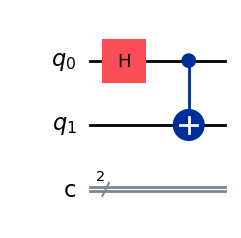

In [2]:
# Building a quantum circuit (Bell State)
qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)
qc.draw("mpl")

In [3]:
# Setting up circuit observables
from qiskit.quantum_info import SparsePauliOp

observable_labels = ["ZZ", "IZ"]
observable = [SparsePauliOp(label) for label in observable_labels]

### Optimize circuits and operators

In [4]:
# Setup Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService

# If setting up Qiskit Runtime for the first time with custom hub/group/instance
# QiskitRuntimeService.save_account(channel="ibm_quantum", token="token", instance="hub/group/project", name="CustomName")
# service = QiskitRuntimeService(instance="hub/group/project")

service = QiskitRuntimeService(instance="ibm-q/open/main")
backend = service.least_busy(simulator=False, operational=True)

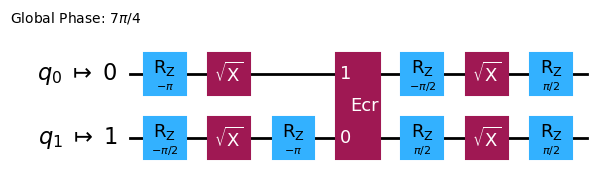

In [5]:
# Build an Instruction Set Architecture (ISA) circuit for transpilation purposes
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)    # Accordingly, you can change the optimization level
isa_circuit = pm.run(qc)
isa_circuit.draw("mpl", idle_wires=False)

### Execute circuit with Primitives

In [6]:
# Apply obervables to the ISA layout
mapped_observables = [obs.apply_layout(isa_circuit.layout) for obs in observable]
mapped_observables

[SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZ'],
               coeffs=[1.+0.j])]

In [7]:
# Build Estmator/Sampler instance
# Depending on the number of jobs you are planning to run, utilize the Batch or Session mode.
# Since we are running a single job, these modes are not required.
estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 100

# Run the Estimator
job = estimator.run([(isa_circuit, mapped_observables)])
print(f"Job ID: {job.job_id()}")

Job ID: cznzph2kzhn0008bm4n0


In [8]:
# Retrieve results
result = job.result()
result

PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(2,), dtype=float64>), stds=np.ndarray(<shape=(2,), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(2,), dtype=float64>), shape=(2,)), metadata={'shots': 128, 'target_precision': 0.1, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 2})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2})

### Analyze the results

In [9]:
# According to your problem, analyze or post-process your results.